# First Zonal Harmonic Forecasting via LSTM

In this notebook, I attempt the most basic prediction for the first zonal harmonic of the external field in response to solar activity. The zonal harmonic, $P_1^0$, is effectively what is measured by the disturbance storm time (Dst) index, except the data that I am trying to reconstruct record only the external field response, while Dst inadvertently includes the fields generated in Earth's subsurface. 

In [1]:
# general
import numpy as np
from sklearn import preprocessing
from scipy.stats import kde
import os
import datetime as dt

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

# file management, io
import pandas as pd
import h5py

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

Using TensorFlow backend.


## Load Data

Let's load the data without gaps as well as the external coefficients.

In [2]:
omni_lr = pd.read_hdf('omni_hourly_1998-2017_nogaps.h5')
coeff = pd.read_hdf('external_coefficients.h5')

The external coefficients report hourly values centered on every half hour, starting at 0:30 on January 1, 1998. The OMNI series, however, are centered on the hour beginning at 0:00, but contain data averaged throughout the subsequent hour (i.e. hour 0 contains data averaged from 0:00-1:00). Thus, both datasets contain data averaged within the same time bins, the bin centers are just denoted differently with the centers at the beginning of the hour for OMNI and at the middle of the hour for the external coefficient series. The external coefficient series contains one less entry than the OMNI data, suggesting that the last entry is missing, since the OMNI series goes until the very last hour of December 31, 2017 but not 0:00 January 1, 2018. While I still need to confirm this, it shouldn't make too much of a difference with these early attempts at training basic networks, so I'll just neglect the last hour of the OMNI data.

Furthermore, we're only interested in the $P_1^0$ term, so let's neglect everything else and consider only the real part of the coefficient series.

In [3]:
omni_lr = omni_lr[0:-1]
p10 = np.real(coeff['enm10']).reshape(-1,1)
t = coeff['time']
t_year = 2000+t/(365.25) # federico's time axis

Finally, let's include previous values of the $P_1^0$ series in the input data, adding a column then to omni_lr.

In [4]:
omni_lr['p10'] = p10

nfeatin = len(omni_lr.columns)

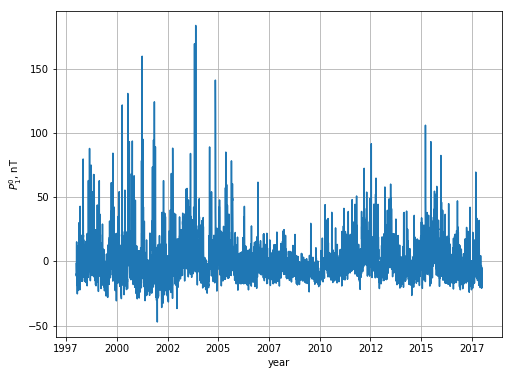

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t_year,p10)
ax.set_ylabel('$P_1^0$, nT')
ax.set_xlabel('year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.grid(True)
plt.show()

## LSTM
Having imported the data, let's design, train, and test the LSTM network for this prediction problem.

### Design

In [17]:
"""
From a data array with observations in rows and features in columns, split 
split into testing and training data based on which rows to use (datain_idx), 
batch_sizes, which features for prediction (incols) and which features as 
targest (outcols). Since we're concerned with time series forecasting, the 
number of steps to forecast ahead is lahead.

IN:
data_in: 
data_out: 
batch_size:
train_percent:
lahead:

OUT:
data_in_train:
data_out_train:
data_in_test:
data_out_test:

 """
def datasplit(data_in, data_out, batch_size, train_percent=0.8, lahead=1):
    nfeatin = data_in.shape[1]
    
    data_in = data_in[0:-lahead,:]
    data_out = data_out[lahead:,:]
    
    nbatch = int(np.floor(data_in.shape[0]/batch_size))
    
    # now construct training and testing sets
    batchrand = np.random.permutation(int(nbatch))
    trainbatch = batchrand[0:int(train_percent*nbatch)]
    testbatch = batchrand[int(train_percent*nbatch):]
    
    trainidx = np.zeros(data_in.shape[0],dtype=bool)
    for batchidx in trainbatch:
        trainidx[batchidx*batch_size:batch_size*(batchidx + 1)] = True
        
    testidx = np.zeros(data_out.shape[0],dtype=bool)
    for batchidx in testbatch:
        testidx[batchidx*batch_size:batch_size*(batchidx + 1)] = True
    
    data_in_train = data_in[trainidx,:]
    data_out_train = data_out[trainidx,:]
    data_in_test = data_in[testidx,:]
    data_out_test = data_out[testidx,:]
    return data_in_train, data_out_train, data_in_test, data_out_test



"""
Given a batch size and training data, train network on the data, and
return the trained network

IN:
dat_in_train (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_train (np.ndarray): data outputs with shape (ndata, nfeat_out)
batch_size (int/double):
nunits (int/double): (default 400) number of hidden units in LSTM
epochs (int): (default 100) epochs for training

OUT:
rnn (keras.Sequential): trained network
hist ()
"""
def train_network(dat_in_train, dat_out_train, batch_size, nunits=400, \
                  epochs=100):
    assert len(dat_in_train.shape) == 3, 'check shape of dat_in_train'
    assert len(dat_out_train.shape) == 2, 'check shape of dat_out_train'
    
    nfeat_in = dat_in_train.shape[2]
    nfeat_out = dat_out_train.shape[1]
    
    # recurrent architecture, create input and output datasets
    rnn = Sequential()
    
    rnn.add(LSTM(nunits, 
            name='LSTM_1',
            stateful=False,
            input_shape=(1,nfeat_in),
            batch_size=batch_size,
            return_sequences=False,
            activation='relu'))
    rnn.add(Dense(nfeat_out,
                  name='Dense'))
    opt = keras.optimizers.RMSprop()
    rnn.compile(loss='mse',optimizer=opt)
    # fit model
    hist = rnn.fit(dat_in_train,
            dat_out_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            verbose=1)
    return rnn, hist

"""
Given a trained network, evaluated it on testing data and plot the
scatter plots.

IN:
dat_in_test (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_test (np.ndarray): data outputs with shape (ndata, nfeat_out)
rnn (keras.Sequential): trained network
batch_size (int/double):
feature_names (list): list of names of output features, length nfeat_out

OUT:
produces plot

"""
def test_network(dat_in_test, dat_out_test, rnn, batch_size, feature_names):
    assert len(dat_in_test.shape) == 3, 'check shape of dat_in_test'
    assert len(dat_out_test.shape) == 2, 'check shape of dat_out_test'
    nfeat_out = dat_out_test.shape[1]
    rnn.reset_states()
    dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)
    plt.figure()
    curtest = np.concatenate((scaler_output.inverse_transform(dat_out_test),\
                              scaler_output.inverse_transform(dat_pred)), axis=1)
    r2 = np.corrcoef(curtest[:,0],curtest[:,1])[0,1]**2
    plt.scatter(curtest[:,0],curtest[:,1])
    k = kde.gaussian_kde(curtest.T)
    x, y = curtest.T
    nbins = 40
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))                                      
    plt.contour(xi,yi,zi.reshape(xi.shape), 5)
    abline(1,0)
    plt.title('%s, $r^2$ = %1.2f' % (feature_names, r2))
    plt.show()

"""
Plot straight line in current axis.
"""
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

### Split and Prepare Data

Let's separate the data into training and testing sets. Let's also normalize all of the data according to the training data.

In [9]:
batch_size = 500
lahead = 6
train_percent = 0.8

In [10]:
# split
data_in_train, data_out_train, data_in_test, data_out_test = datasplit(omni_lr.values, p10, batch_size, train_percent, lahead)

# normalize
scaler_input = preprocessing.MinMaxScaler()
data_in_train = scaler_input.fit_transform(data_in_train)
data_in_test = scaler_input.transform(data_in_test)

scaler_output = preprocessing.MinMaxScaler()
data_out_train = scaler_output.fit_transform(data_out_train)
data_out_test = scaler_output.transform(data_out_test)

# reshape input data
data_in_train = data_in_train.reshape(-1,1,nfeatin)
data_in_test = data_in_test.reshape(-1,1,nfeatin)

Epoch 1/20
140000/140000 [==============================] - 3s 24us/step - loss: 0.0020
Epoch 2/20
140000/140000 [==============================] - 1s 9us/step - loss: 8.7912e-04
Epoch 3/20
140000/140000 [==============================] - 1s 9us/step - loss: 5.4544e-04
Epoch 4/20
140000/140000 [==============================] - 1s 9us/step - loss: 4.3501e-04
Epoch 5/20
140000/140000 [==============================] - 1s 9us/step - loss: 3.8364e-04
Epoch 6/20
140000/140000 [==============================] - 1s 9us/step - loss: 3.5215e-04
Epoch 7/20
140000/140000 [==============================] - 1s 9us/step - loss: 3.2969e-04
Epoch 8/20
140000/140000 [==============================] - 1s 10us/step - loss: 3.1087e-04
Epoch 9/20
140000/140000 [==============================] - 1s 9us/step - loss: 2.9341e-04
Epoch 10/20
140000/140000 [==============================] - 1s 9us/step - loss: 2.7998e-04
Epoch 11/20
140000/140000 [==============================] - 1s 9us/step - loss: 2.7017e-04

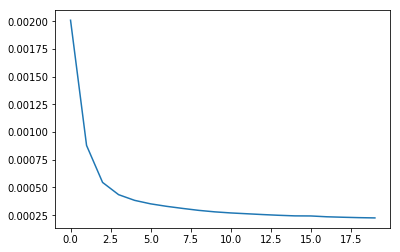

In [11]:
rnn, hist = train_network(data_in_train, data_out_train, batch_size, epochs=20)
plt.plot(hist.history['loss'])

### Test

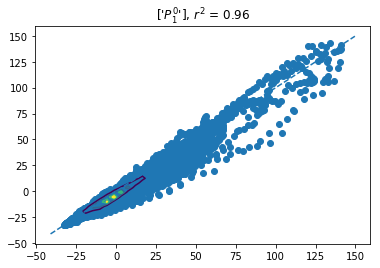

In [18]:
test_network(data_in_test, data_out_test, rnn, batch_size, ['$P_1^0$'])